In [1]:
%load_ext lab_black

# respyabc

--- 
Project for the course in Scientific Computing | Winter 2020/2021, M.Sc. Economics, Bonn University | [Manuel Huth](https://github.com/manuhuth)
 
---

In this notebook I showcase how to use the *respyabc* package, which builds on the *pyabc* and the *respy* package, to estimate the model first model from *Keane and Wolpin* 1994.

> Emmanuel Klinger, Dennis Rickert, Jan Hasenauer (2018); pyABC: distributed, likelihood-free inference. Bioinformatics.

> Janos Gabler, Tobias Raabe (2020); respy - A framework for the simulation and estimation of Eckstein-Keane-Wolpin models.

#### Using respyabc

* Clone from [GitHub](https://github.com/manuhuth/respyabc) or install via [conda](https://conda.anaconda.org/manuhuth). For purposes of this notebook we reccomend to download the repository from [GitHub](https://github.com/manuhuth/respyabc).
---

Loading all modules and functions is simply done by

In [88]:
import respy as rp
import numpy as np
import pandas as pd

import time

from pyabc.visualization import plot_kde_matrix_highlevel
from pyabc.visualization import plot_model_probabilities
from respyabc.distances import compute_mean_squared_distance
from respyabc.evaluation import compute_point_estimate
from respyabc.evaluation import plot_2d_histogram
from respyabc.evaluation import plot_history_summary
from respyabc.evaluation import plot_history_summary_no_kde
from respyabc.evaluation import plot_kernel_density_posterior
from respyabc.evaluation import plot_multiple_credible_intervals
from respyabc.models import compute_model
from respyabc.models import transform_multiindex_to_single_index
from respyabc.respyabc import respyabc
from respyabc.tools import convert_time
from respyabc.tools import plot_normal_densities

---
# 1 From respy and pyABC to respyabc
---

In this notebook I showcase the Python package respyabc, which offers a likelihood-free inference procedure for finite-horizon discrete choice models. The heart of respyabc are the two open-source packages respy (Gabler and Raabe; [2020](https://respy.readthedocs.io/en/latest/)) and pyABC (Klinger et al.; [2018](https://watermark.silverchair.com/bty361.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAr0wggK5BgkqhkiG9w0BBwagggKqMIICpgIBADCCAp8GCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM6WLi_HWh7fPxGjBoAgEQgIICcGn-J3-8gZEH93eB8Gphm7F3wCf9ux_fLjnoFR3ijbt06MKMNS0LPjKjApel0G5Ke2uZjYPBFRwC-aTWVQRLYNB2xpCRbHOzyPfYQrtoYlpmuHxy-JFAzxbwmv7DdOytmVwVyq6qGnx6Xzxls9nvdFdon1MPsCZ0Mj-x_Li6el_oGv0Eq9rY6Sd4QTicRuNCQ7Ci9GkXjDaSQR64hASP-dbUQjJUwlPsPTwUvGW8vTcHLP9LMj0gBaXvD3XM9MB0XtkNfGCBjxk1XmZV9bwJhD6FlI2AHfBGY3Avpusjjs3JPEL4HFt4DVVqhPWMD2TGgBGh9m62NDfV2-EH9bLc1XnTcWXk1FduyrNxomUmAsDgoSFAIndmVK2SS-wJC49iy1FnoCYt5l2XgLstI-0w9xcKNfMOks912e_S1rI1v012rgLydcybeyH--TcRl9tWjwKT_v4xwsTCMFpXnQqGOLa2HA93OuOpC9QHSmYaP2cp0a5Wq4seZArM28wYlF9D2nf0qjZRrlqqgLYXZmE_FEBStxiCeWMDYGq2t5A3w4buIqUsPepIQ70XJrwnIjUI8s0IAZUaQAqw2GRxtKLl-Q7qVj1YQnclN9E_LdioHe1_Er8KJoORZDARY_r1MWVn6o5TNWtgZhLyb-aoUbHnjgipUcZiXy-9NNZ122WcG4nVrms9eWQ5RC4boNdaEsBXxRKmuJUhtvgJswgrN9rUeidye7Ppqy13cD_LZwkYlDmKX9MAUnFj37X2kKtol1X84i3L_djRk2D20LhrDht9W4XwL5OK4SsEwRh_7GO8xP7hN57fttzHbMaV-qjg2K40EQ)]. We structured the notebook in the following way. First, we review the relevant theory that is needed to understand the presented analysis. Second, we showcase how single-parameter inference can be conducted by varying over the discount factor and using the activity's relative choice frquencies $a$ as well as the wage moments $w$ as summary statistics. Subsequently, we conduct inference for the two constants $\alpha_1, \alpha_2$ of the work equations $R_1$ and $R_2$ and afterwards for all non-zero equation parameters of the work equations. Before concluding, we show how respyabc can be used for model selection. We aim to explain all functionalities of respyabc within the analysis by giving code examples and explanations.  

**Model**\
respy is used to specify and simulate models. Currently, the first parameterization of the Keane and Wolpin [1994](https://www.jstor.org/stable/2109768?seq=1#metadata_info_tab_contents) model, which we subsequently abbreviate with KW94, is the default standard. The incorporation of further and custom models is planned for the next release. We briefly sketch the KW94 model in this notebook to make the notebook self contained. A broader description of the model is given within Keane and Wolpin [1994](https://www.jstor.org/stable/2109768?seq=1#metadata_info_tab_contents).

Let $\tau \in \{0, \dotsc, T \}$ be a finite number of periods in which an individual $i \in I$ decides between working in occupation A ($a=1$) or B ($a=2$), schooling ($a=3$) and staying at home ($a=4$). For each decision an individual receives a choice-specific reward $R_a$ with

\begin{align}
R_1(\tau) &= w_{1\tau}=\exp{\left(\alpha_1 + \beta_{11} h_\tau + \gamma_{11} k_{1\tau} + \gamma_{12} k_{1\tau}^2 +  \gamma_{17} k_{2\tau} +  \gamma_{18} k_{2\tau}^2 + \varepsilon_{1\tau}  \right)} \\
R_2(\tau) &= w_{2\tau} = \exp{\left(\alpha_2 + \beta_{21} h_\tau + \gamma_{21} k_{2\tau} + \gamma_{22} k_{2\tau}^2 +  \gamma_{27} k_{1\tau} + \gamma_{28} k_{1\tau}^2 + \varepsilon_{2\tau}  \right)} \\
R_3(\tau) &= \alpha_3 + \beta_{hc} \mathbb{I}(h_\tau \geq 12) + \beta_{rc}[1-\mathbb{I}(a_{\tau-1} = 3)] + \varepsilon_{3\tau} \\
R_4(\tau) &= \alpha_4 + \varepsilon_{4\tau}.
\end{align}

$h_\tau$ denotes the years of schooling in period $\tau$ and $k_{a'\tau}$ denotes the work experience in occupation $a' \in \{1,2\}$. Using squared terms within the exponential function of $R_1(\tau)$ and $R_2(\tau)$ allows for a parabola shape of work experience on logarithmic rewards following the popular Mincer [1974](https://eric.ed.gov/?id=ED103621) equation. $w_{a'\tau}$ are wages that are equal to the respective rewards and individuals earn them from working in one of the two occupations. Setting the wages equal to the rewards excludes *after-work rewards*. Note that in the KW94 model we use $\gamma_{17}, \gamma_{18}, \alpha_3,\beta_{hc}=0$. 

$\mathbb{I}(h_\tau \geq 12)$ is an indicator function that indicates if an individual has 12 or more years of schooling experience. $\beta_{a'1}, \beta_{a'2}, \gamma_{a'1}, \gamma_{a'2}, \gamma_{a'7}$ and $\gamma_{a'8}$ are coefficients to determine the influence of years of schooling and working on the rewards of occupation. $\beta_{h c}$ is the coefficent of having 12 or more years of schooling and $\beta_{rc}$ is the reward of going back to school after at least one year of abscence. $\mathbb{I}(a_{\tau} = 3)$ is a dummy that is one if the individual attended school in period $\tau$.
$\alpha_a$ are choice specific reward constants. $\varepsilon_{a\tau}$ are random shocks that can be correlated within a period $t$ and are a-priori  unknown to the individual.\
The optimizatzion problem that the forward-looking individual has to solve in any period $\tau$ is to maximize the expected sum of all discounted period utilities from period $\tau$ to period $T$. 

\begin{align}
v_\tau(s_\tau) = \mathbb{E} \left[\sum_{j=0}^{T-\tau} \delta^j u_{\tau+j}\left[s_{\tau+j}, a_{\tau+j}(s_{\tau+j})\right] \mid s_\tau  \right], 
\end{align}
where $s_\tau$ is the given state in period $\tau$ and $\delta \in (0,1]$ the discount factor. Using respy this optimization problem can be solved applying the principle of optimality from Bellmann ([1952](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1063639/)). With respy the user can calibarate her model by using empirical or simulated data of independent individuals via maximum likelihood estimation and estimation via the method of simulated moments. 
respyabc offers a likelihood-free alternative via approximate Bayesian computing (ABC) using a sequential Monte-Carlo (SMC) scheme. This is implemented by using pyABC. To go into more detail of pyABC we first introduce some notation and define summary statistics for observed/simulated data that we use within the analysis.

**Data summary statistics**\
Let $Y^{(q)} \in \mathbb{R}^{(T+1) \times |I|}$ be the matrix collecting the observed/simulated outcome of interest $q$ for each individual $i \in I$ at all periods $\tau \in \{0, \dotsc, T \}$. Precisely, $y^{(q)}_{\tau i}$ is the entry in row $\tau$ and column $i$ of $Y^{(q)}$ and represents the outcome of interest $q$ for individual $i$ in period $\tau$. In our application, the outcome of interest are either the wages $w$ or the choices $a$, such that $q \in \{w, a \}$.
Let $s^{(q)}$ be a function that transforms the population data into chosen summary statistics $S^{(q)} = s^{(q)}(Y^{(q)})$, with $S^{(q)} \in \mathbb{R}^{(T+1) \times \zeta^{(q)}}$ being a matrix containing $\zeta^{(q)}$ summary statistics of the population, measured at each period $\tau$.\
$s^{(a)}(Y^{(a)})$ is defined to be the function that returns the choice frequencies of any alternative $a \in \{1,2,3,4\}$ for each period $\tau$. Thus, $\zeta^{(a)} = 4$ and the $\tau$-th row of $S^{(a)}$ is defined as 
\begin{align}
\frac{1}{|I|}  \begin{pmatrix} \sum_{i = 1}^{|I|} \mathbb{I}(y^{(a)}_{\tau i} = 1) & \sum_{i = 1}^{|I|} \mathbb{I}(y^{(a)}_{\tau i} = 2) & \sum_{i = 1}^{|I|} \mathbb{I}(y^{(a)}_{\tau i} = 3) & \sum_{i = 1}^{|I|} \mathbb{I}(y^{(a)}_{\tau i} = 4) \end{pmatrix}'.
\end{align}
Analogously, $s^{(w)}(Y^{(w)})$ is defined to be the function that returns the row means and row standard deviations of $Y^{(w)}$ as columns, such that the $\tau$-th row of $S^{(w)}$ is defined as
\begin{align}
\begin{pmatrix} \overline{y}^{(w)}_{\tau} & \frac{1}{|I|-1} \sum_{i = 1}^{|I|} \left(y^{(a)}_{\tau i} - \overline{y}^{(w)}_{\tau} \right)  \end{pmatrix}',
\end{align}
where $\overline{y}^{(w)}_{\tau}=\frac{1}{|I|}  \sum_{i = 1}^{|I|} y^{(w)}_{\tau i}$
Thus, $\zeta^{(w)} = 2$. 

**pyABC**\
We can see one simulation of the KW94 model with a subsequent computation of the summary statistics as a mapping $\mathcal{M}^{(q)}$ from a $d$- dimensional input vector $\theta \in \Theta \subset \mathbb{R}^n$, with parameter space $\Theta$, to summary statistics of the simulated data 
\begin{align}
S^{(q)} = s^{(q)}(Y^{(q)}) =\mathcal{M}^{(q)}(\theta). 
\end{align}
$\theta$ consists in general of (some of) the $\alpha, \beta$ and $\gamma$ coefficients presented above. Additionally, the correlations and standard deviations of the period specific disturbances $\varepsilon_{at}$ and the discount factor can be seen as parameters within $\theta$. In this notebook we subsequently increase the number of parameters to analyze and finally conduct analysis for all non-zero parameters of the KW94 model. 

For inference purposes we are interested in the likelihood of a parameter vector given observed data $Y^{(q)}$. This likelihood is reflected by the *posterior distribution* $p(\theta|Y^{(q)})$. We can describe the posterior distribution in terms of the *likelihood* $f(Y^{(q)}| \theta)$ and the *prior distribution* $\pi(\theta)$
\begin{align}
    p(\theta|Y^{(q)}) = \frac{f(Y^{(q)}| \theta) \pi(\theta) }{\int f(Y^{(q)}| \theta') \pi(\theta') d\theta'} \propto f(Y^{(q)}| \theta) \pi(\theta) .
\end{align}

For complicated $\mathcal{M}^{(q)}$ the posterior might not be traceable at all. In these cases we can use ABC to estimate parameters likelihood-free. The idea is to sample parameters $\theta$ such that the simulated model output $\hat{Y}^{(q)}$ is *close* to the observed data $Y^{(q)}$. For computational convenience, we do not use the data of $Y^{(q)}$ and $\hat{Y}^{(q)}$ but their summary statistics $S^{(q)}$ and $\hat{S}^{(q)}$ instead. For individuals in the sense of the KW94 model their order in the population, e.g. which individual is placed in which column of $Y^{(q)}$, is redundant and we need to use a 'sample location' which is invariant to the ordering. This is the case for our summary statistics $a$ and $w$ since they are computed using first and second moments.  

To define what being *close* means for two matrices of summary statistics we need to define a suitable distance $d^{(q)}:\mathbb{R}^{(T+1) \times \zeta^{(q)}} \times \mathbb{R}^{(T+1) \times \zeta^{(q)}} \to \mathbb{R_+}$. In our application, we use the averaged squared Frobenius-Norm of the differences between both matrices, which is just the mean of the squarred differences in each cell of the summary matrices. A simulated output $\hat{Y}_j^{(q)}$ is defined to be close to $Y^{(q)}$ if $d(S^{(q)}, \hat{S}_j^{(q)}) < \epsilon$ for a fixed small $\epsilon > 0$.

\begin{align}
    p(\theta|S^{(q)}) = \frac{f(S^{(q)}| \theta) \pi(\theta) }{p(S^{(q)})} \approx \frac{\int  f(S| \theta) \pi(\theta) \mathbb{I}\left[d(S^{(q)},S) < \epsilon \right] dS}{p(S^{(q)})} = p_\epsilon(\theta|S^{(q)}),
\end{align}
such that $\lim\limits_{\epsilon \to 0} p_\epsilon(\theta|S^{(q)}) = p(\theta|S^{(q)})$. 

In the abc-smc algorithm we simulate whole populations of simulated parameters $\{\hat{\theta}_{tj}^{(q)}\}_{j=0, \dotsc, p_t}$ for a fixed $t=0,1, \dotsc, n$, where $t$ indicates the simulation iteration and $j$ indicates the $j$-th simulated accepted data sample, to approximate the true parameters. Note that the population size $p_t$ has a subscript $t$, since it usually varies over the iterations. You can find a note on that in Klinger et al. [2018](https://watermark.silverchair.com/bty361.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAr0wggK5BgkqhkiG9w0BBwagggKqMIICpgIBADCCAp8GCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM6WLi_HWh7fPxGjBoAgEQgIICcGn-J3-8gZEH93eB8Gphm7F3wCf9ux_fLjnoFR3ijbt06MKMNS0LPjKjApel0G5Ke2uZjYPBFRwC-aTWVQRLYNB2xpCRbHOzyPfYQrtoYlpmuHxy-JFAzxbwmv7DdOytmVwVyq6qGnx6Xzxls9nvdFdon1MPsCZ0Mj-x_Li6el_oGv0Eq9rY6Sd4QTicRuNCQ7Ci9GkXjDaSQR64hASP-dbUQjJUwlPsPTwUvGW8vTcHLP9LMj0gBaXvD3XM9MB0XtkNfGCBjxk1XmZV9bwJhD6FlI2AHfBGY3Avpusjjs3JPEL4HFt4DVVqhPWMD2TGgBGh9m62NDfV2-EH9bLc1XnTcWXk1FduyrNxomUmAsDgoSFAIndmVK2SS-wJC49iy1FnoCYt5l2XgLstI-0w9xcKNfMOks912e_S1rI1v012rgLydcybeyH--TcRl9tWjwKT_v4xwsTCMFpXnQqGOLa2HA93OuOpC9QHSmYaP2cp0a5Wq4seZArM28wYlF9D2nf0qjZRrlqqgLYXZmE_FEBStxiCeWMDYGq2t5A3w4buIqUsPepIQ70XJrwnIjUI8s0IAZUaQAqw2GRxtKLl-Q7qVj1YQnclN9E_LdioHe1_Er8KJoORZDARY_r1MWVn6o5TNWtgZhLyb-aoUbHnjgipUcZiXy-9NNZ122WcG4nVrms9eWQ5RC4boNdaEsBXxRKmuJUhtvgJswgrN9rUeidye7Ppqy13cD_LZwkYlDmKX9MAUnFj37X2kKtol1X84i3L_djRk2D20LhrDht9W4XwL5OK4SsEwRh_7GO8xP7hN57fttzHbMaV-qjg2K40EQ).\
The iterative ABC-SMC procedure works as follows (Toni et al.; [2008](https://royalsocietypublishing.org/doi/10.1098/rsif.2008.0172))

1. Initialize run. \
    1.1 Draw candidates $\hat{\theta}_{0j}$ unconditionally from the prior distribution $\pi(\theta)$ and accept if $d^{(q)}\left(\hat{S}_{0j}^{(q)}, S^{(q)}\right) < \epsilon_0$. Repeat until $p_0$ simulations have been accepted and set them as initial population $\hat{\theta}_0 = \left\{\hat{\theta}_{01}^{(q)}, \dotsc, \hat{\theta}_{0p_0}^{(q)} \right\}$.\
    1.2 Set weights $\omega_{0j} = 1/p_0$ 
2. Set $\epsilon_1$ to the median distance of the previous population.\
    2.1 Sample $\hat{\theta}_{1j}$ from $\hat{\theta}_0$ with weights $\omega_0$ and perturb it with a perturbation kernel $K_1$ (see Toni et al. ([2008](https://royalsocietypublishing.org/doi/10.1098/rsif.2008.0172))). Accept if $d^{(q)}\left(\hat{S}_{1j}^{(q)}, S^{(q)}\right) < \epsilon_1$. Repeat until $p_1$ simulations have been accepted and set them as population $\hat{\theta}_1 = \left\{\hat{\theta}_{11}^{(q)}, \dotsc, \hat{\theta}_{1p_1}^{(q)} \right\}$.\
    2.2 Set weights to $\omega'_{1j} = \frac{\pi(\theta_{1j})}{\sum_{j=1}^{p_1} \omega_{0j} K_1\left(\theta_{1j}, \theta_{0j}\right)}$ and normalize them such that their sum equals one to obtain $\omega_{1j}$.
3. Proceed with the same procedure until the $n$-th population $\hat{\theta}_n = \left\{\hat{\theta}_{n1}^{(q)}, \dotsc, \hat{\theta}_{np_n}^{(q)} \right\}$ is simulated using $\epsilon_n$.

In respyabc the user needs to define $\epsilon_n$, which is to say, the minimum epsilon and therefore the acceptance threshold. The acceptance rate is off course very sensitive to the choice of $\epsilon_n$. On the one hand, if $\epsilon_n$ is too large the approximation error is too high and we tend to accept samples generated by parameters that are far away from the true ones. On the other hand, if $\epsilon_n$ is too small, we might decline too many samples and the algorithm has a hard time computing estimates. 

## KW94model settings

We use respy to load the settings of the KW94 model and inspect the true parameter we will use to get on overview of the magnitudes we vary over. If desired, the user can use ``params`` to get a glimpse on how the parameters look like. For readability, we refrain from showing the parameters in `params` in the standard notebook.

In [89]:
params, options, data_stored = rp.get_example_model("kw_94_one")

To run respyabc efficiently, it is necessary that the distance $d^{(q)}(\cdot)$ we observe is (close to) zero if we simualte the model with the true parameter vector $\theta$. Hence, we want that $\mathcal{M}^{(q)}(\theta)=S^{(q)}$ is invariant to the choice of the random simulation seed. We achieve this in the KW94 setting by choosing a suitable large number of individuals and decision periods, such that the summary statistics are invariant to the seeds. We keep the standards of $T=40$ simulated periods and $|I|=1000$ individuals for each run of the KW94 model.

In [90]:
periods = options["n_periods"]
agents = options["simulation_agents"]
f"The KW94 model consists of {periods} periods and {agents} agents."

'The KW94 model consists of 40 periods and 1000 agents.'

---
# 2 Inference
---

## 2.1 Using a single parameter

In this subsecton we vary over the discount factor delta, which is in the KW94 model set to $\delta = 0.95$ such that the model of interest becomes $\mathcal{M}^{(q)}(\delta)=S^{(q)}$. We compare how respyabc performs for both types of summary statistics $q=a,w$.

To simulate the true population in respyabc we need to define the model that is to be simulated and choose between $d^{(a)}(\cdot)$ and $d^{(w)}(\cdot)$ to compute the distance between 2 populations. Naming the parameter `delta_delta` seems to be unnecassarily cumbersome in the first place. However, note that `params` is a multi-indexed data frame but pyABC only works with single-indexed data frames. Thus, respyabc melts both indices to an index and divides them by an underscore, such that the parameter key and the data frame index can be called within one string but the parameter is still uniquely identified in `params`. The parameters are, according to pyABC, defined in a dictionary. Note that we do not need to pass the parameter of inetrest here as additional argument for simulating the data since we use the default value that is already in ``params``. We do so, however, to showcase the user how changing the  reference data set can be done. 

In [91]:
model_to_simulate = rp.get_simulate_func(params, options)
parameter_true_single_delta_a = {"delta_delta": 0.95}

### 2.1.1 Using choice frequencies

In this first example we use $q=a$. We can pass this to respyabc by specifying `descriptives="choice_frequencies"`. Moreover, respyabc allows to modify the parameter values over which we do not vary and the custom options. Note that settings in `parameter_for_simulation` are overwritten by setting the true parameter through the dictionary. We distinguish between varying and fixed parameters since the function `compute_model` is used within the ABC_SMC scheme. We set the parameters and options of the model to the to their default values by spassing `parameter_for_simulation=params` and `options_for_simulation=options` to the function.

**Setting up the data**

In [92]:
np.random.seed(12)
pseudo_observed_data_a = compute_model(
    parameter_true_single_delta_a,
    model_to_simulate=model_to_simulate,
    parameter_for_simulation=params,
    options_for_simulation=options,
    descriptives="choice_frequencies",
)

To varify that $\mathcal{M}^{(q)}(\delta)$ is invariant to the seed random seed, we run the simulation again using a different seed.

In [93]:
np.random.seed(123)
pseudo_observed_data_a_test = compute_model(
    parameter_true_single_delta_a,
    model_to_simulate=model_to_simulate,
    parameter_for_simulation=params,
    options_for_simulation=options,
    descriptives="choice_frequencies",
)

We can compare two distances by using the mean squared difference between both matrices of summary statistics.

In [94]:
seed_distance_a = compute_mean_squared_distance(
    pseudo_observed_data_a_test, pseudo_observed_data_a
)
f"The distance is: {seed_distance_a :0.2f}"

'The distance is: 0.00'

**Choosing the pyABC settings**\
We set the size of the pyABC samples to 500 and the maximum possible number of drawn populations to $n=10$. The excact magnitudes in applications depend on the respective data. In general, if a rigorous analysis is desired, the maximum number of drawn pyABC populations should not be reached, since this tool is more for convenience to reduce computation time and give the user the possibility to check the results.

In [95]:
population_size = 500
max_nr_populations = 10

$\epsilon_n$ is set to be 0.05. This was found to be a valid epsilon in previous simulations. We choose a uniform prior $\delta \sim U(\cdot)$. Choosing a uniform prior has the advantage that the user sets the distribution bounds as bounds for the posterior distribution, yielding more control on which values to allow. Specifying priors must be done in a dictionary with the parameter name corresponding to the multiindex of `params` as key and a list containing another list that specifies the distribution parameters and the type of the distribution. Currently only the uniform distribution (`"uniform"`) and the normal distribution (`"norm"`) are implemented.

In [96]:
minimum_epsilon = 0.05
delta_prior_low_single_delta_a = 0.9
delta_prior_length_single_delta_a = 0.09
parameters_prior_single_delta_a = {
    "delta_delta": [
        [delta_prior_low_single_delta_a, delta_prior_length_single_delta_a],
        "uniform",
    ]
}

`"delta_delta"` is the key identifier, `delta_prior_low_single_delta_a` is the lower bound of the uniform distribution and `delta_prior_length_single_delta_a` is the length of the uniform interval and **not** the upper bound. We chose this type setting of the uniform distribution in order to be in line with `pyABC`, which follows `scipy`.  

After specifying all relevant parameters, inference is conducted by using the `respyabc` function. To run the fucntion we need to specify model $\mathcal{M}^{(q)}$ by `model`, define the prior distribution $\pi(\delta)$ by `parameters_prior`, the true data $S^{(q)}$ by `data`, the distance measure $d^{(q)}$ by `compute_mean_squared_distance`, the type of descriptive statistics $q$ by `descriptives`, the first population size $p_0$ by `population_size_abc`, the maximum number of populations by `max_nr_populations_abc` and $\epsilon_n$ by `minimum_epsilon_abc`.

**Conduct inference**\
We keep track of the simulation time to give a glimpse on how long simulation times are. The values we have specififed for `distance_abc`, `descriptives`, `population_size` and `minimum_epsilon` are the default values of `respyabc`. We do specify them in this firste xample to showcase how they must be specified and in subsequent functions to allow easy changes over the whole notebook by just changing the relevant name of the object that is passed to the respective argument of the function.

In [11]:
np.random.seed(1234)
start_single_delta_a = time.perf_counter()
history_single_delta_a = respyabc(
    model=compute_model,
    parameters_prior=parameters_prior_single_delta_a,
    data=pseudo_observed_data_a,
    distance_abc=compute_mean_squared_distance,
    descriptives="choice_frequencies",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=minimum_epsilon,
)
end_single_delta_a = time.perf_counter()

In [97]:
time_single_delta_a, unit_single_delta_a = convert_time(
    end_single_delta_a - start_single_delta_a
)
f"The respyabc run took {time_single_delta_a:0.2f} {unit_single_delta_a}"

'The respyabc run took 35.17 minutes'

**Bias evaluation**\
To evaluate how accurately we have estimated $\delta$ we use a point estimate, kernel densitie estimates, credible intervals and take a visual look at the convergence of the ABC-SMC scheme by inspecting acceptance rates and the trajectory of $\epsilon_i$.\
We compute a point estimate as weighted average $\sum_{j=1}^{p_n} \omega_{nj} \hat{\theta}_{nj}^{(a)}$ of the $n$-th population. This can be done using respyabc's `compute_point_estimate` function by simply passing the created history object `history_single_delta_a`.

In [98]:
estimate_single_delta_a = compute_point_estimate(history_single_delta_a).loc[
    "estimate", "delta_delta"
]
f"The point estimate for delta is: {estimate_single_delta_a:0.4f}"

'The point estimate for delta is: 0.9502'

In [99]:
rel_bias_delta_a = (
    estimate_single_delta_a / parameter_true_single_delta_a["delta_delta"] - 1
)
f"The relative bias for delta is: {rel_bias_delta_a *100:0.4f}%"

'The relative bias for delta is: 0.0215%'

**Graphical assessment**\
The point estimate is already very accurate. To become a better understanding on how the posterior distribution looks like and evolves over $t$, we plot kernel density estimates using normal kernels. This can be done by simply passing the created history object, the parameter name and the desired bounds of the axes to the respyabc function `plot_kernel_density_posterior`.

**Figure 1 - Univariate kernel density estimates of the posterior using relative choice frequencies**

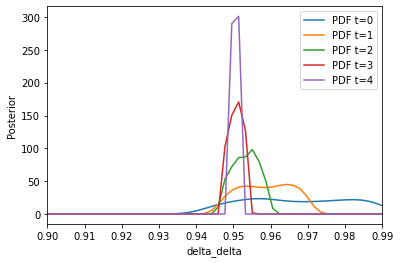

In [100]:
xmax_single_delta_a = delta_prior_low_single_delta_a + delta_prior_length_single_delta_a
plot_kernel_density_posterior(
    history=history_single_delta_a,
    parameter="delta_delta",
    xmin=delta_prior_low_single_delta_a,
    xmax=xmax_single_delta_a,
)

We observe that the posterior distribution centers, as expected, with increasing $t$ and thus decreasing $\epsilon$. Since the function `respyabc` returns a [ABCSMC](https://pyabc.readthedocs.io/en/latest/api_inference.html) class, all model assessments tools from pyABC are feasible to apply as well. Hence, we can use the well implemented functions to track the evolution of $\epsilon_t$, the $p_t$ and plot credible intervals. respyabc offers a wrapper `plot_history_summary` for a fast implementation that only requires the history, parameter name and the reference value.\
The plot in the upper left corner depicts the credibility intervals at levels $0.5,0.9,0.95$. They can be interpreted as: Given the observed data, the intervals contain the true unknown parameter with the respective probability. The plot also shows how the point estimate (Mean) and the maximum value of the kernel density estimates evolve over $t$. The latter shows where the largest point mass of the posterior is and gives a glimpse on which parameter is around this largest point mass. The plot in the upper right depicts the trajectory of the epsilons. The plots in the second row depict the acceptance rates and the required samples that were needed to reach the desired sample size $p_t$.

**Figure 2 - Single-parameter model evaluation using choice frequencies**

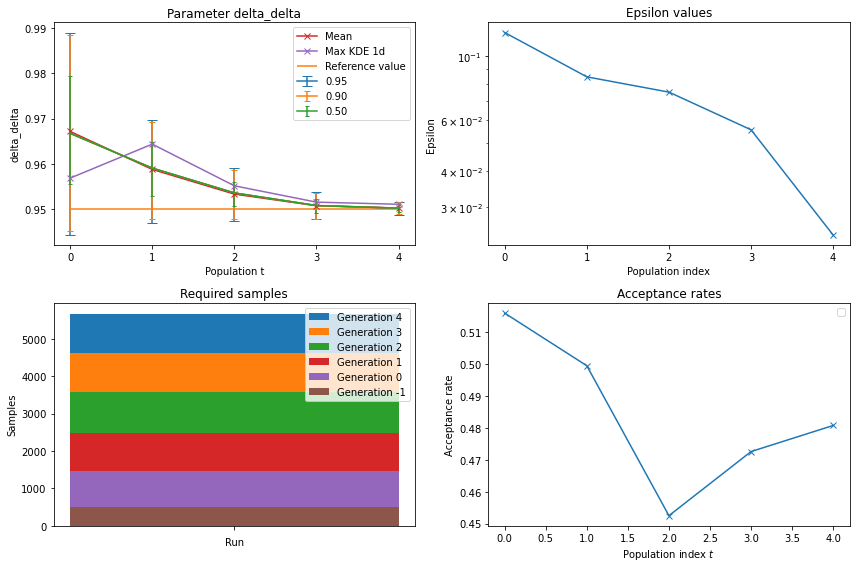

In [101]:
plot_history_summary(
    history=history_single_delta_a, parameter_name="delta_delta", parameter_value=0.95
)

### 2.1.2 Using wage moments

In the next step, we conduct the same analysis varying over $\delta$ but choose $q=w$. To use the wage moments, we first need to compute the exemplary data set with the wage moments as summary statistics. We can do so by setting `descriptives="wage_moments"`. All other parameters are equal to the specififcation using $q=a$. We set the same seed to obtain the same data. As done in the previous analysis, we compare the distance for two seeds to see if the summary statistics are invariant to the choice of the seed.

In [102]:
np.random.seed(12)
pseudo_observed_data_single_delta_w = compute_model(
    parameter_true_single_delta_a,
    model_to_simulate=model_to_simulate,
    parameter_for_simulation=params,
    options_for_simulation=options,
    descriptives="wage_moments",
)
np.random.seed(123)
pseudo_observed_data_single_delta_w_test = compute_model(
    parameter_true_single_delta_a,
    model_to_simulate=model_to_simulate,
    parameter_for_simulation=params,
    options_for_simulation=options,
    descriptives="wage_moments",
)

In [103]:
seed_distance_single_delta_w = compute_mean_squared_distance(
    pseudo_observed_data_single_delta_w_test, pseudo_observed_data_single_delta_w
)
f"The distance is: {seed_distance_single_delta_w :0.2f}"

'The distance is: 0.00'

**Conduct inference**\
With regard to the previous analysis we only need to adjust the data by `data=pseudo_observed_data_single_delta_w` and the type of summary statistics by `descriptives="wage_moments"`. Moreover, since the magnitudes of the wage moments ar ehigher, we set $\epsilon_n=10^6$ which turned out to be a reasonable magnitude.

In [18]:
np.random.seed(1234)
start_single_delta_w = time.perf_counter()
history_single_delta_w = respyabc(
    model=compute_model,
    parameters_prior=parameters_prior_single_delta_a,
    data=pseudo_observed_data_single_delta_w,
    distance_abc=compute_mean_squared_distance,
    descriptives="wage_moments",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=10 ** 6,
)
end_single_delta_w = time.perf_counter()

In [104]:
time_single_delta_w, unit_single_delta_w = convert_time(
    end_single_delta_w - start_single_delta_w
)
f"The respyabc run took {time_single_delta_w:0.2f} {unit_single_delta_w}"

'The respyabc run took 48.34 minutes'

**Bias evaluation**\
Computing the point estimate is done by using the weighted mean, analogously to the case where $q=a$. We observe that the estimate is exactly equal to the parameter and therefore even closer than the estimate using the choice frequencies. However, the for $q=w$ the algorithm has a larger $n$ and thus we could choose $\epsilon_n$ smaller for $q=a$ to see if this improves the estimate. Moreover, both estimates are very close and we recommend further analysis to determine which summary statistics perform better. 

In [105]:
estimate_single_delta_w = compute_point_estimate(history_single_delta_w).loc[
    "estimate", "delta_delta"
]
f"The point estimate for delta is: {estimate_single_delta_w:0.4f}"

'The point estimate for delta is: 0.9500'

In [106]:
rel_bias_delta_w = (
    estimate_single_delta_w / parameter_true_single_delta_a["delta_delta"] - 1
)
f"The relative bias for delta is: {rel_bias_delta_w*100:0.4f}%"

'The relative bias for delta is: 0.0030%'

**Graphical assessment**\
We plot the same model evaluations as for the previous analysis. The kernel density estimates of the posterior become again more and more centered around the true value for increasing $t$, indicating that the variance of the population decreases and the mean becomes equal to the true value. 

**Figure 3 - Univariate kernel density estimates of the posterior using wage moments**

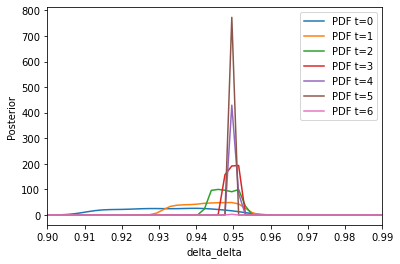

In [107]:
xmax_single_delta_a = delta_prior_low_single_delta_a + delta_prior_length_single_delta_a
plot_kernel_density_posterior(
    history=history_single_delta_w,
    parameter="delta_delta",
    xmin=delta_prior_low_single_delta_a,
    xmax=xmax_single_delta_a,
)

Further summary statistics underline our findings. The mean estimator is already at the second population very accurate and smoothes even closer to the true value for higher $t$. The trajectory of the epsilons and the acceptance rates look similar to the plots using the choice frequencies.

**Figure 4 - Single-parameter model evaluation using wage moments**

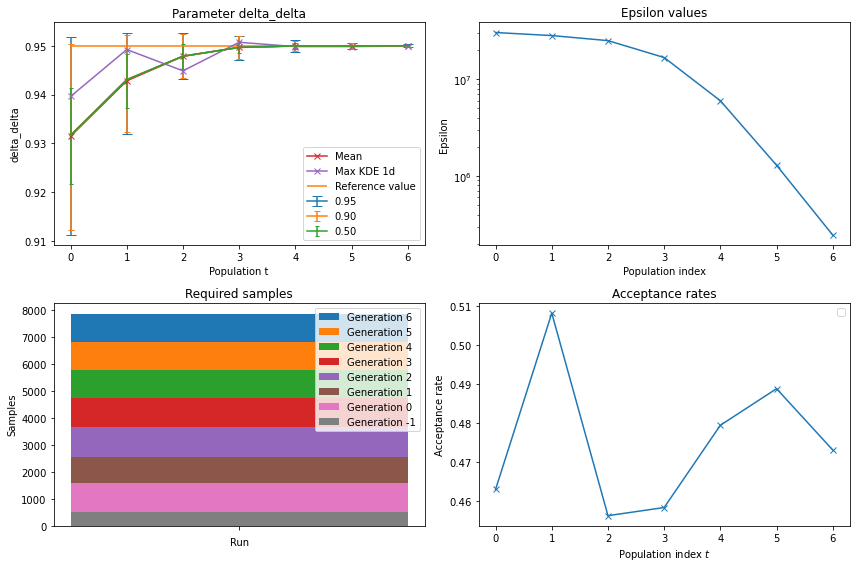

In [108]:
plot_history_summary(
    history=history_single_delta_w, parameter_name="delta_delta", parameter_value=0.95
)

## 2.2 Multiple parameters

In this subsection we extend the analysis and vary over multiple parameters. First, we use the wage constants such that $\theta = \begin{pmatrix} \alpha_1 & \alpha_2 \end{pmatrix}'$ and second we use all non-zero parameters of the work equations. We only use choice frequencies as summary statistics in his chapter. Extensions can be done simultaneously to the single parameter case by changing the respective strings to "wage_moments". 

### 2.2.1 Two parameters

We first vary over two parameters to showcase the transition from a single parameter model to a multiple parameter model. Our parameters of choice are the constants $\alpha_1$ and $\alpha_2$ from equations $R_1$ and $R_2$ such that the model becomes $\mathcal{M}^a(\alpha_1, \alpha_2)$. Note that for a rigororues comparison between a single and a two-parameter model, we would need to compare both single parameter models of $\alpha_1$ and $\alpha_2$ with their respective two-parameter model. We refrain from doing so since we want to keep the notebook concise and this would require conducting the same analysis four times. Thus, we decided to use the work specific constants in the two-parameter case. \

**Choosing the pyABC settings**\
As in the single parameter case, we need to define prior distributions. Note that we only specify marginal priors and do not specify a bivariate distribution. For multiple parameters, we can simply define them in one dictionary with the keys equal to the melted multiindex from the data frame `params` and the values equal to the desired magnitude.

In [109]:
parameters_prior_multi_alpha = {
    "wage_a_constant": [[9, 1], "uniform"],
    "wage_b_constant": [[8, 1], "uniform"],
}

**Conduct inference**\
Armed with the priors, running `respyabc` with multiple parameters is equivalent to the previous single parameter chapter.

In [24]:
np.random.seed(234)
start_multi_alpha = time.perf_counter()
history_multi_alpha = respyabc(
    model=compute_model,
    parameters_prior=parameters_prior_multi_alpha,
    data=pseudo_observed_data_a,
    distance_abc=compute_mean_squared_distance,
    descriptives="choice_frequencies",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=minimum_epsilon,
)
end_multi_alpha = time.perf_counter()

In [110]:
time_multi_alpha, unit_multi_alpha = convert_time(end_multi_alpha - start_multi_alpha)
f"The respyabc run took {time_multi_alpha:0.2f} {unit_multi_alpha}"

'The respyabc run took 35.84 minutes'

**Bias evaluation**\
The estimates are computed for each parameter analogously to the single parameter case and displayed within one data frame.

In [111]:
estimate_multi_alpha = compute_point_estimate(history_multi_alpha).loc["estimate", :]
estimate_multi_alpha

name
wage_a_constant    9.406300
wage_b_constant    8.688667
Name: estimate, dtype: float64

The abolut and the relative bias are considerably larger as for the $\delta$ parameter.

In [112]:
true_wage_a_constant = params.loc["wage_a", "constant"]["value"]
true_wage_b_constant = params.loc["wage_b", "constant"]["value"]
true_wage_constants = np.array([true_wage_a_constant, true_wage_b_constant])
rel_bias_two = (np.array(estimate_multi_alpha) / true_wage_constants - 1) * 100
df_rel_bias_two = pd.DataFrame(
    data=rel_bias_two, index=estimate_multi_alpha.index, columns=["relative bias in %"]
)
df_rel_bias_two

,relative bias in %
name,
wage_a_constant,2.131383
wage_b_constant,2.460694


**Graphical assessment**\
By indicating the desired number of rows and columns the user can decide on how to arrange the graph of multiple credibility interval plots. For $\alpha_1$ we observe that the mean estimator deviates for higher $t$ from the true value, whereas $\alpha_2$ stays stable starting with $t=2$.

**Figure 5 - Two-parameter credibility intervals**

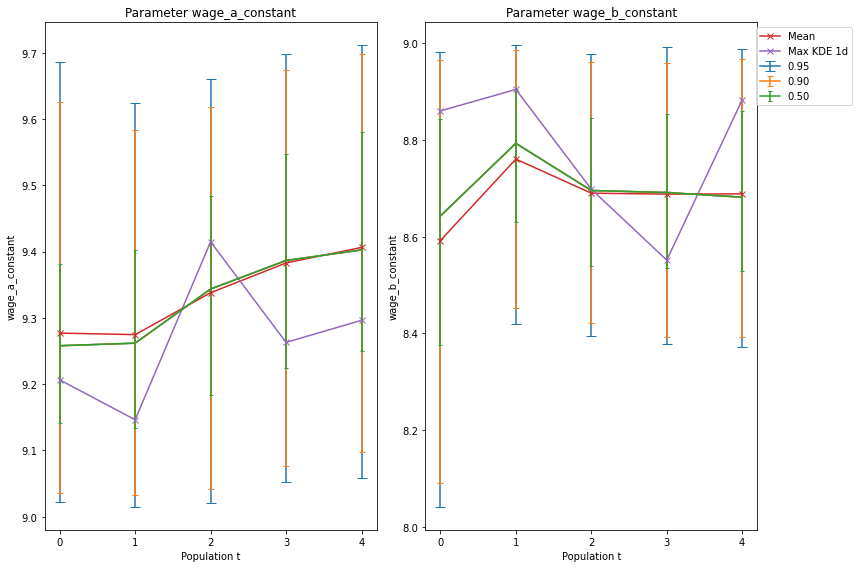

In [113]:
plot_multiple_credible_intervals(
    history=history_multi_alpha,
    number_rows=1,
    number_columns=2,
    parameter_names=["wage_a_constant", "wage_b_constant"],
)

For the kernel densities, we do not only exploit their one-dimensional but their two-dimensional structure. The graph indicates the bivariate kernel density estimates for all simulated populations, using a multivariate normal kernel. The orange dot is the location of the true parameter values. The colo scheme indicates the value of the estimated bivariate density function. As for the single parameter case, we observe that for increasing $t$, the density's variance becomes lower. In the last graph $t=4$ we can observe that there is a line-like area with a high density that has the true value more to its left surface. The estimated mean point $(9.41, 8.67)'$ lies in the middle of that *colored line area*. the intuition could be that we compute the estimates as weighted average over the sample and thus we end up with the center point of the area containing the high densities.

In [ ]:
xmin = parameters_prior_multi_alpha["wage_a_constant"][0][0]
xmax = xmin + parameters_prior_multi_alpha["wage_a_constant"][0][1]
ymin = parameters_prior_multi_alpha["wage_b_constant"][0][0]
ymax = xmin + parameters_prior_multi_alpha["wage_b_constant"][0][1]

**Figure 6 - Bivariate kernel density estimates of the posterior**

/home/manuel/Documents/respyabc/respyabc/evaluation.py:462: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(3, ncol, t + 1)


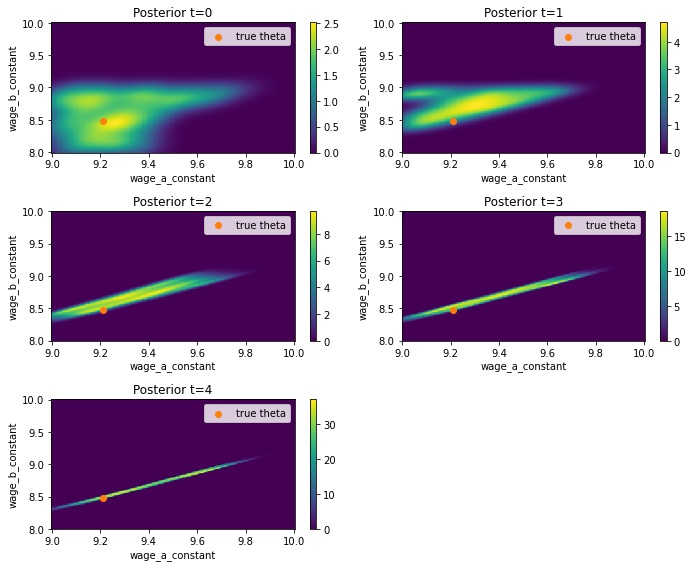

In [114]:
plot_2d_histogram(
    history=history_multi_alpha,
    parameter_names=["wage_a_constant", "wage_b_constant"],
    parameter_true=[9.21, 8.48],
    xmin=xmin,
    xmax=xmax,
    ymin=ymin,
    ymax=ymax,
)

Additionally to the previous model summaries, respyabc also alllows to plot the efefctive sample size $p_t$. We offer a short cut by offering all four plots below in one function `plot_history_summary_no_kde`. The $\epsilon_t$ values and the acceptance rates show different trajectories as in the single parameter case. Especially the value of $\epsilon_t$ decreases for $t=0$ to $t=1$ rapidly but smoothly afterwards. This smooth descend indicates that the distance between the estimated samples $\hat{Y}^{(a)}$ and the true sample $Y^{(a)}$ decreases slower as for the single parameter example.

**Figure 7 - Two-parameter model evaluation**

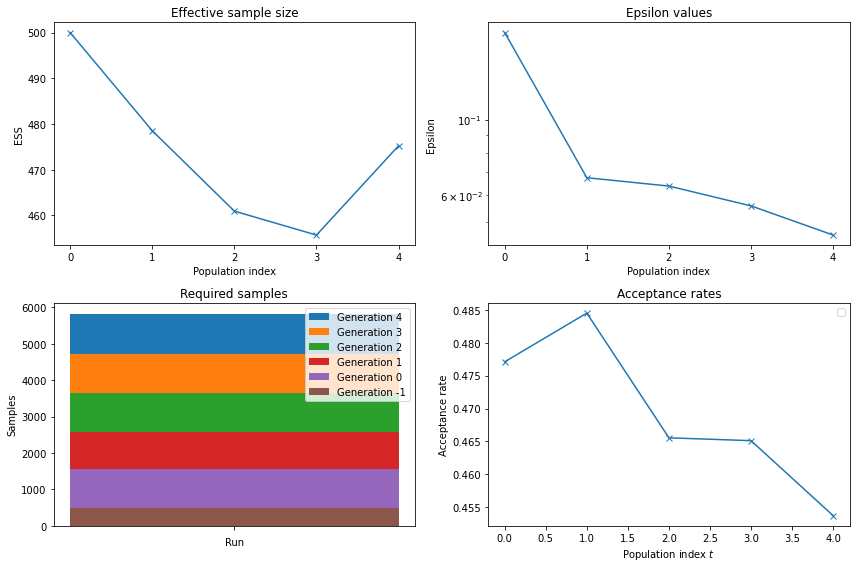

In [115]:
plot_history_summary_no_kde(history_multi_alpha)

**describe plots**

### 2.2.2 All non-zero parameters

The transition from a two-parameter model to a multiple parameter model is straightforward. the user simply needs to extend the steps of indicating teh desired number of parameters instead of two parameters. In this example we vary over all parameters of the wage equations $R_1$ and $R_2$ that are non-zero in the KW94 specification and the discount factor. We stay within the activity's choice frequency framework $q=a$ and set the parameter vector of interest to $\theta = \begin{pmatrix} \delta & \alpha_1 & \beta_{11} & \gamma_{11} & \gamma_{12} & \alpha_2 & \beta_{21} & \gamma_{21} & \gamma_{22} & \gamma_{27} & \gamma_{28}  \end{pmatrix}'$.

**Choosing the pyABC settings**\
Defining the marginal priors is analogously done as in the two-parameter model by specifying all of them in one dictionary. As in the previous models we stick to unfiorm priors since they allo to set bounds. Setting bounds is in partiuclar useful to keep the parameters $\gamma_{12}$ and $\gamma_{22}$ negative to obtain a Mincer-like downward-opened parabola. We keep the prior bounds rather low in this example to increase the speed of the ABC-SMC algorithm and recommend to play around with the bounds for a deeper analysis. 

In [116]:
parameters_prior_multi = {
    "delta_delta": [
        [delta_prior_low_single_delta_a, delta_prior_length_single_delta_a],
        "uniform",
    ],
    "wage_a_constant": [
        [
            parameters_prior_multi_alpha["wage_a_constant"][0][0],
            parameters_prior_multi_alpha["wage_a_constant"][0][1],
        ],
        "uniform",
    ],
    "wage_a_exp_edu": [[0, 0.1], "uniform"],
    "wage_a_exp_a": [[0, 0.1], "uniform"],
    "wage_a_exp_a_square": [[-0.05, 0.05], "uniform"],
    "wage_b_constant": [
        [
            parameters_prior_multi_alpha["wage_b_constant"][0][0],
            parameters_prior_multi_alpha["wage_b_constant"][0][1],
        ],
        "uniform",
    ],
    "wage_b_exp_edu": [[0, 0.1], "uniform"],
    "wage_b_exp_b": [[0, 0.1], "uniform"],
    "wage_b_exp_b_square": [[-0.05, 0.05], "uniform"],
    "wage_b_exp_a": [[0, 0.1], "uniform"],
    "wage_b_exp_a_square": [[-0.05, 0.05], "uniform"],
}

**Conduct inference**\
As in the previous specifications the code to run `respyabc` does not change for more parameters after we have specififed the priors and are happy to keep the same settings as in the previous analysis.

In [31]:
np.random.seed(2345)
start_multi = time.perf_counter()
history_multi = respyabc(
    model=compute_model,
    parameters_prior=parameters_prior_multi,
    data=pseudo_observed_data_a,
    distance_abc=compute_mean_squared_distance,
    descriptives="choice_frequencies",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=minimum_epsilon,
)
end_multi = time.perf_counter()

In [117]:
time_multi, unit_multi = convert_time(end_multi - start_multi)
f"The respyabc run for delta using choice frequencies took {time_multi:0.2f} {unit_multi}"

'The respyabc run for delta using choice frequencies took 1.81 hours'

**Bias evaluation**\
The point estimates are again returned in one data frame.

In [118]:
estimate_multi = compute_point_estimate(history_multi).loc["estimate", :]
estimate_multi

name
delta_delta            0.931159
wage_a_constant        9.514182
wage_a_exp_a           0.045997
wage_a_exp_a_square   -0.017593
wage_a_exp_edu         0.052689
wage_b_constant        8.783145
wage_b_exp_a           0.064983
wage_b_exp_a_square   -0.004419
wage_b_exp_b           0.062015
wage_b_exp_b_square   -0.002937
wage_b_exp_edu         0.065745
Name: estimate, dtype: float64

The relative biases are considerably high, especially for the parameters responsible for the downward parabola shape. These parameters are, however, low in magnitude and therefore show high relative biases while having comparable low absolute biases.

In [119]:
params_single_index = transform_multiindex_to_single_index(params, "category", "name")
true_parameter_multi = np.array(params_single_index.loc[estimate_multi.index]["value"])
rel_bias_multi = (np.array(estimate_multi) / true_parameter_multi - 1) * 100
df_rel_bias_multi = pd.DataFrame(
    data=rel_bias_multi, index=estimate_multi.index, columns=["relative bias in %"]
)
df_rel_bias_multi

,relative bias in %
name,
delta_delta,-1.983245
wage_a_constant,3.302736
wage_a_exp_a,39.383554
wage_a_exp_a_square,3418.503946
wage_a_exp_edu,38.654182
wage_b_constant,3.574824
wage_b_exp_a,195.376200
wage_b_exp_a_square,783.862434
wage_b_exp_b,-7.440788


**Graphical assessment**\
Plotting all credibility interval plots can be straightforwardly done by specifying the desired number of rows and columns. We observe that almost all aprameter do not show a clear convergence pattern. this could indicate that we chose $\epsilon_n$ too high. However, to keep running times low, we refrain from lowering it here in the notebook but encourage interested readers to try lower values.

**Figure 8 - Multi-parameter credibility intervals**

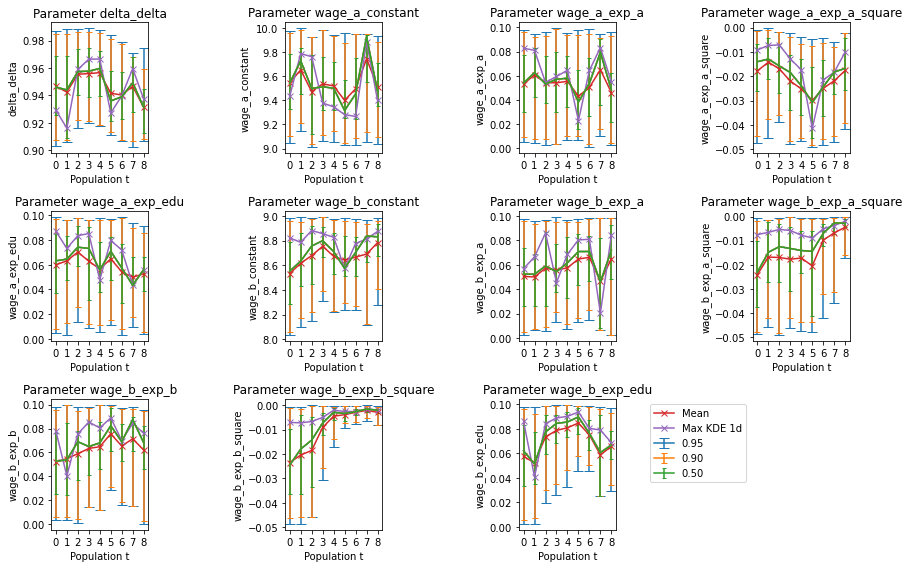

In [120]:
par_names = estimate_multi.index
plot_multiple_credible_intervals(
    history=history_multi,
    parameter_names=par_names,
    number_rows=3,
    number_columns=4,
    delete_axes=[2, 3],
    legend_location="lower_right",
)

Similar to the two parameter case we plot the bivariate kernel density estimates but only for $t=n$. They are depicted in the lower triangle of the plot matrix. The upper triangle contains the unweighted bivariate scatter plots of the final samples $\hat{\theta}_n$. The orange dot is the true parameter point. The main diagonal depicts the marginal kernel density estimates. all axes are rstricted to the parameter bounds set by the uniform priors. 

In [ ]:
true_values = {}
count = 0
for i in estimate_multi.index:
    true_values[i] = true_parameter_multi[count]
    count += 1

limits = {}
keys = parameters_prior_multi.keys()
for i in keys:
    limits[i] = (
        parameters_prior_multi[i][0][0],
        parameters_prior_multi[i][0][0] + parameters_prior_multi[i][0][1],
    )

**Figure 9 - Univariate and Bivariate kernel density estimates of the posteriors**

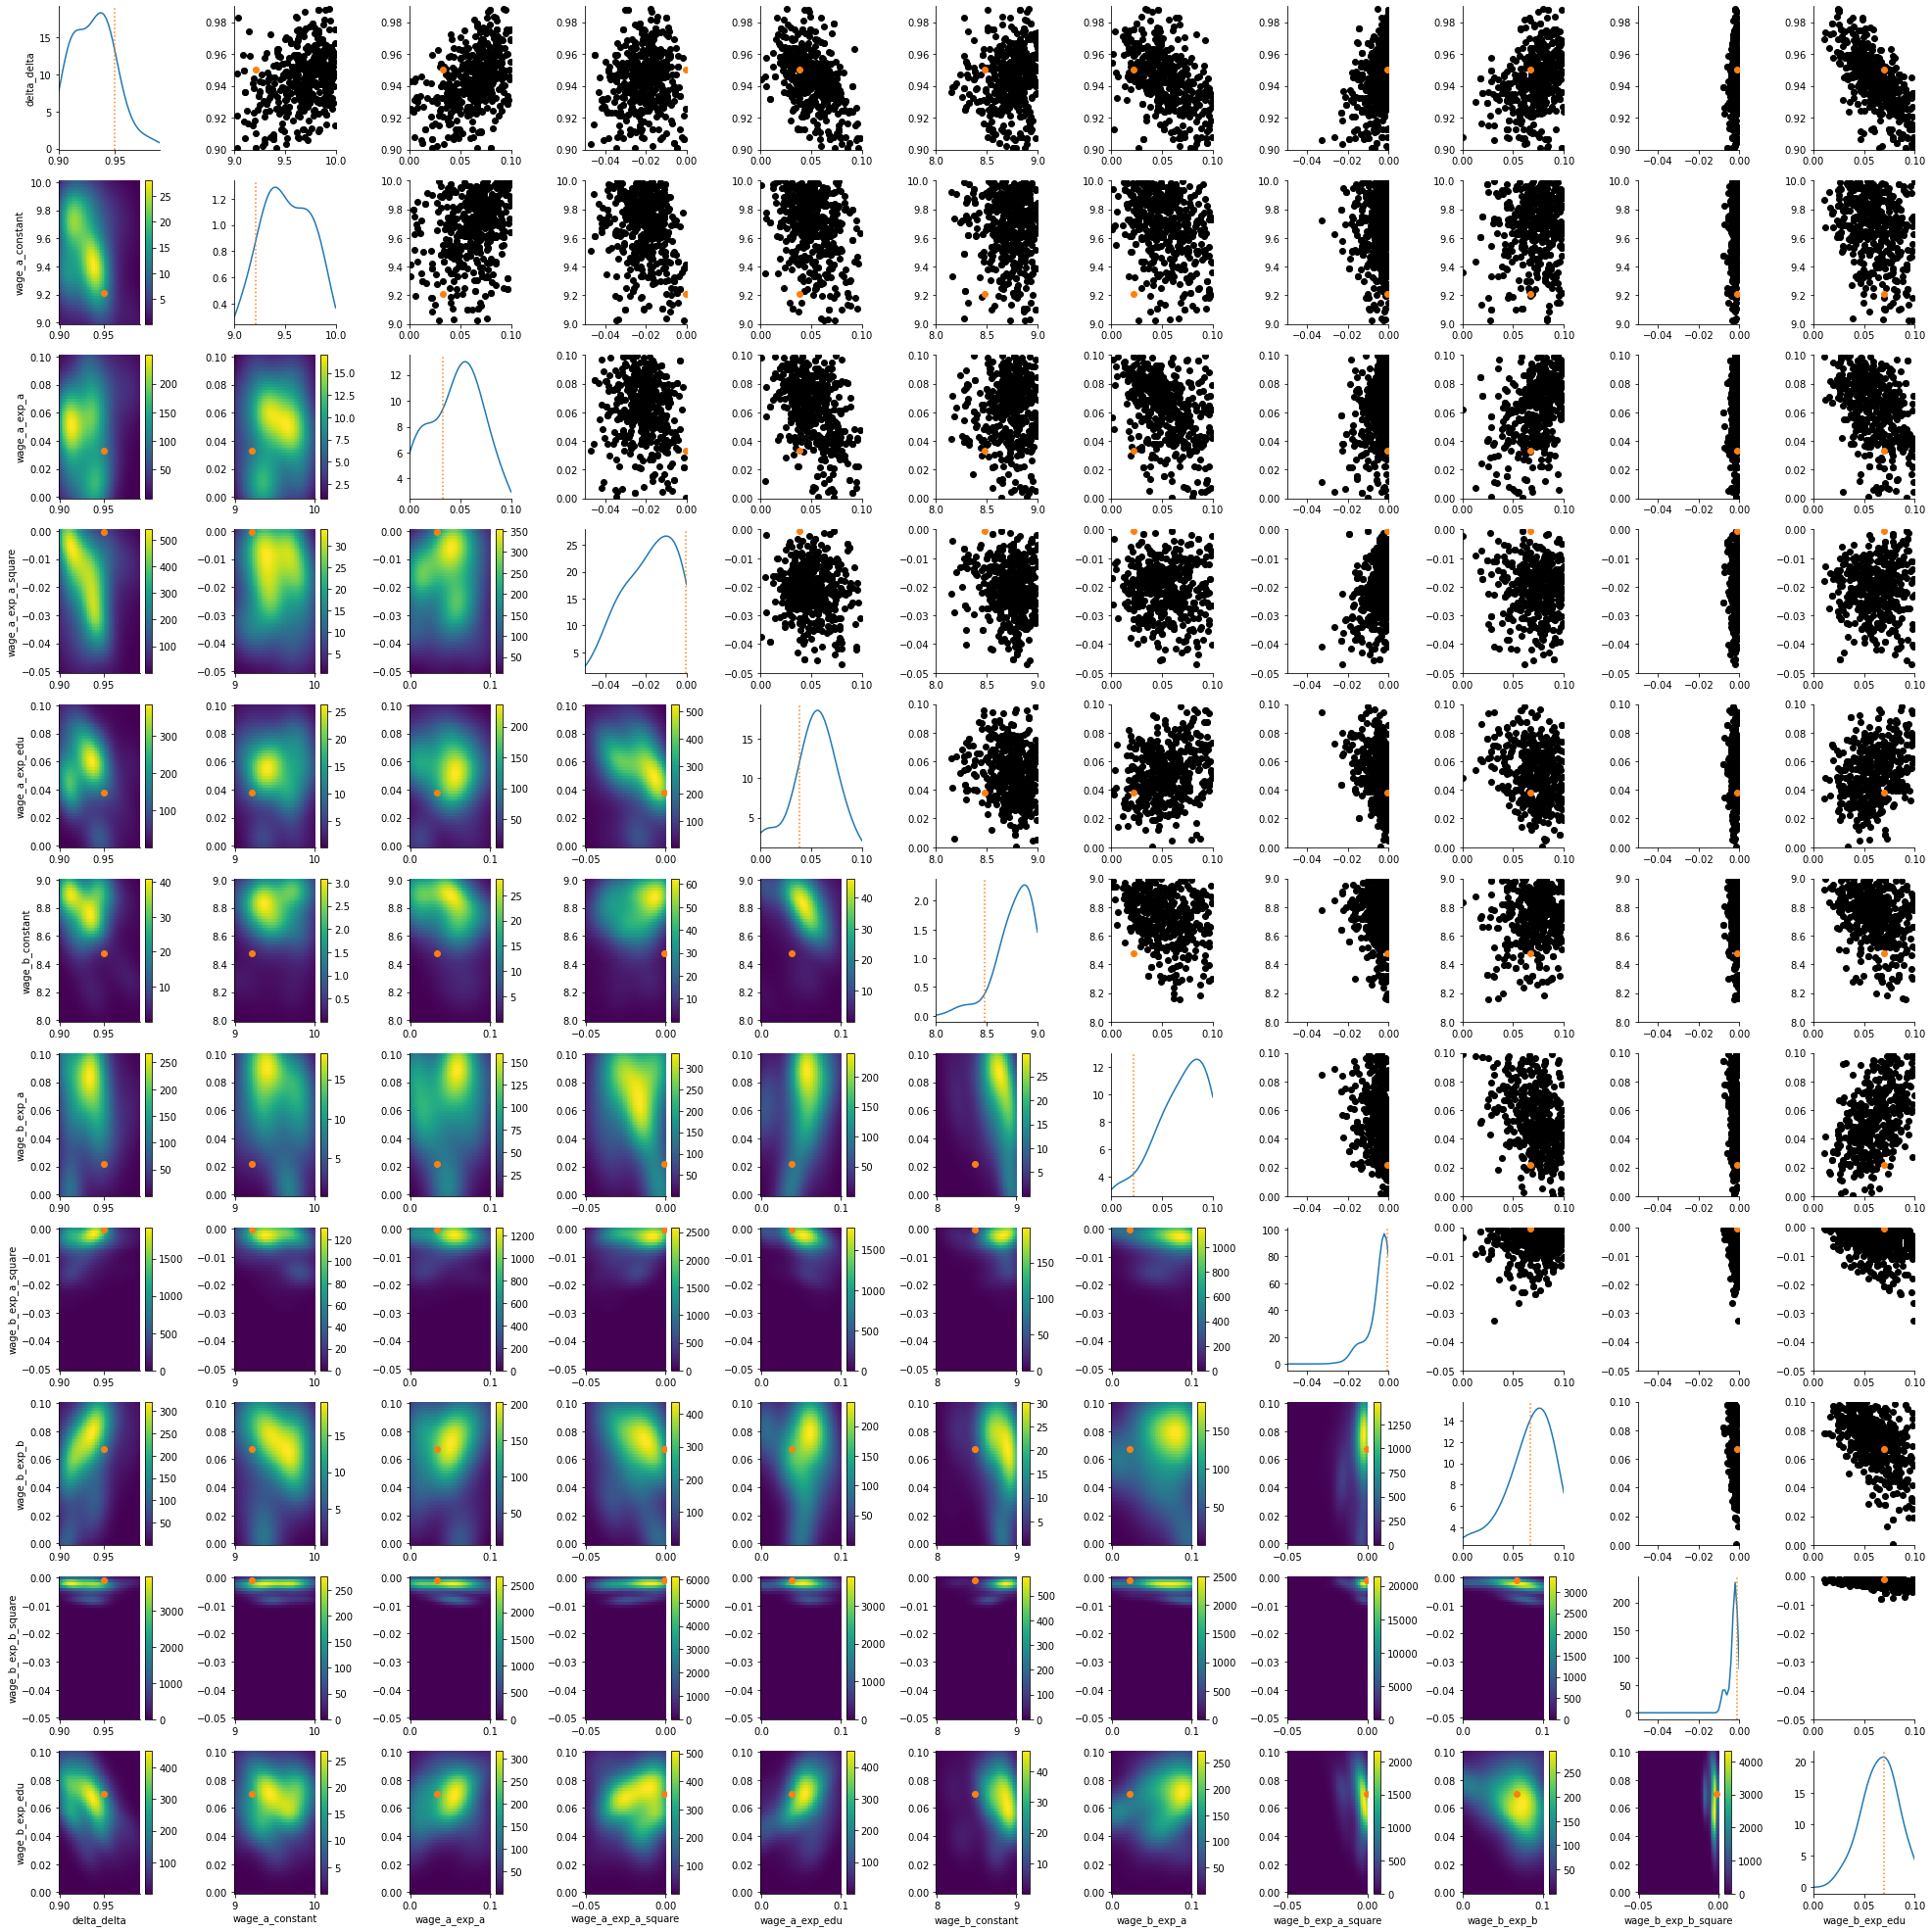

In [121]:
kde_matrix = plot_kde_matrix_highlevel(history_multi, refval=true_values, limits=limits)

The trajectory of $\epsilon_t$ is close to a straight line and the acceptance rate shows a similar structure as for the single parameter case. The sample sizes decrease rapidly to around 50-100 after the first population. This reduction is liklely to have reduced the time of the ABC-SMC algorithm remarkably and indicates that we could consider a lower population size for the multi-parameter setting.

**Figure 10 - Multi-parameter model evaluation**

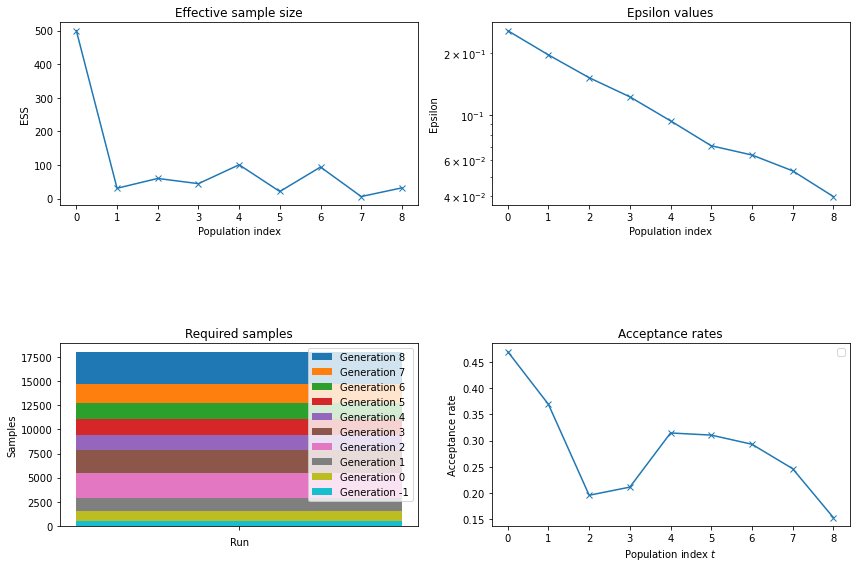

In [122]:
plot_history_summary_no_kde(history_multi)

# 3 Model selection
---

As closing example, we give a brief example on how respyabc can be ueed for model selection. To do so we compare two KW94 models that are actually identical but differ in their prior distribution. As prior we now use normal distributions. Defining the models to compare can be done by defining two models in one list. For an inside to the theory behind model selection we point to Toni et al. ([2008](https://royalsocietypublishing.org/doi/10.1098/rsif.2008.0172)).

In [123]:
models = [compute_model, compute_model]

We need to define an exemplary parameter to vary over. Our first choice would be the discount factor $\delta$ which, as explained in the single parameter chapter, should be estimated with a uniform prior. However, for purposes of showing how model selection works it is more suitable to use normal priors instead of uniform priors since the latter rather serve as setting bounds over a equally likely grid. Hence, we decided to use the influence of education on the wages in the first job.\

**Define prior distributions**\
To define the priors we first set their means and variances to specify the normal distributions. Model zero has the true parameter as mean and model one deviates by $40\%$. The variances are equal and set to $0.004$. 

In [124]:
parameter_selection = "wage_a_exp_edu"
mu0 = params.loc["wage_a", "exp_edu"][0] * 1
var0 = 0.004
mu1 = params.loc["wage_a", "exp_edu"][0] * 0.6
var1 = 0.004

To specify the priors the user specifies a prior dictionary for each model, as done previously for parameter inference, and defines one list containing both prior dictionaries.

In [125]:
parameter_prior_selection_model0 = {parameter_selection: [[mu0, var0], "norm"]}
parameter_prior_selection_model1 = {parameter_selection: [[mu1, var1], "norm"]}
parameter_prior_selection = [
    parameter_prior_selection_model0,
    parameter_prior_selection_model1,
]

We plot the density of the priors along with the true value. The prior of model one is slightly moved to the left compared to the prior using the true mean. 

**Figure 11 - Chosen normal prior densities**

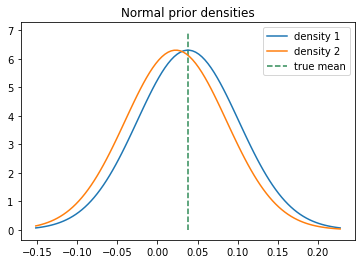

In [126]:
plot_normal_densities(
    mu1=mu0,
    var1=var0,
    mu2=mu1,
    var2=var1,
    vertical_marker=params.loc["wage_a", "exp_edu"][0],
)

**Conduct model selection**\
After specifying the models with the respective priors one can run `respyabc` similary to the inference case. We only need to specify that we are doing model selection by setting `model_selection=True`.

In [127]:
np.random.seed(34)
start_selection = time.perf_counter()
history_selection = respyabc(
    model=models,
    parameters_prior=parameter_prior_selection,
    data=pseudo_observed_data_a,
    distance_abc=compute_mean_squared_distance,
    descriptives="choice_frequencies",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=minimum_epsilon,
    model_selection=True,
)
end_selection = time.perf_counter()

In [128]:
time_multi, unit_multi = convert_time(end_multi - start_multi)
f"The respyabc run for delta using choice frequencies took {time_multi:0.2f} {unit_multi}"

'The respyabc run for delta using choice frequencies took 1.81 hours'

**Model selection assessment**\
The results can be viewed by using the `history.get_model_probabilities()` argument or by using the `plot_model_probabilities()` function. We obtain probabilities in favor of model zero for both runs of the ABC-SMC algorithm. After the first run model one has a probability of around $1/3$. In the second run model one is already classified as being very unlikely by assigning a probability of around $0.2\%$. Thus, the algorithm chooses the true model already after only two runs.

In [129]:
model_probabilities = history_selection.get_model_probabilities()
model_probabilities

m,0,1
t,,
0,0.574000,0.426000
1,0.984948,0.015052
2,1.000000,0.000000


**Figure 12 - Model selection probabilities**

<AxesSubplot:title={'center':'Model probabilities'}, xlabel='Population index', ylabel='Probability'>

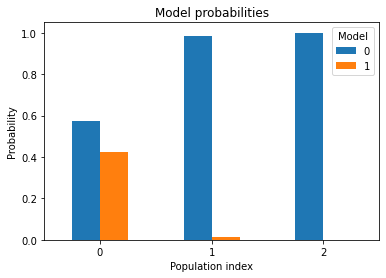

In [130]:
plot_model_probabilities(history_selection)

# 4 Concluision
---

Within this notebook we have showed how likelihood-free inference for the KW94 model can be conducted using respyabc and the ABC-SCM scheme. We conducted inference for single-parameter and multi-parameter settings and showcased a brief example of bayesian model selection. We found that single-parameter inference for the discount factor yields accurate, and in particular converging, point estimates, regardless of the choice of the summary statistics. Moreover, the univariate kernel density estimates of the posterior center more and more with decreasing variance for later populations, giving evidence of reliable convergence to the true parameter. For the two-parameter model we find that the posterior's bivariate kernel density estimates become more centered for later populations. However, they do not center around the true parameter vector.\
Using all non-zero parameters from the wage equations of the KW94 model shows some high deviations in the relative bias of the parameters. Nevertheless, the certain parameters are rather small and the absolute bias is not high. Bivariate and univariate kernel density estimates of the posteriors enhance the evidence that some parameters fail to estimate the true parameters accurately. 

Our analysis suffers from several restrictions. Most strikingly, it might be necessary to decrease the value of $\epsilon_n$ and, regarding on how low we set $\epsilon$, to increase the maximum number of runs. We have not done so in the notebook to keep the run time of the notebook moderate. However, we expect to get a better understanding of the parameter convergence with regard to $t$. Moreover, we do not aim to compare how single-parameter estimation performs compared to multi-parameter estimation. \
Even though it seems intuitive to use the relative choice frequencies or the first and second wage moments as summary statistics and we provided reasonable arguments in the introduction, we have not tested different summary statistics yet. We aim to incorporate an analysis that addresses this issue by comparing different possible summary statistics within the next update.\
A similar argument applies to the distance norm we have used. It seems reasonable to choose the mean squared distances but since other matrix norms, like the whole range of $p$-norms, are available, we desire to incorporate multiple distance functions in the package and to offer an exemplary notebook that compares these distances.